In [ ]:
#imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

#setings
#username:povergrrr
#key:4ab9a2b112addb191cdbdf82bacaae50
dataset_kaggle = "https://www.kaggle.com/oracledevrel/"
dataset_folder = "formulaaihackathon2022"
dataset_uri = dataset_kaggle+dataset_folder
dataset_file = dataset_folder + "/weather.csv"
DATATYPE = "datetime64[ns]"
FORMAT = '%Y-%m.%d %H:%M:%S'
DECISION = ['M_AIR_TEMPERATURE']
TIMESTAMP = 'TIMESTAMP'
columns = [
            'TIMESTAMP',
            'M_SESSION_UID',
            'M_TRACK_ID',
            'M_TRACK_TEMPERATURE', #wywalone bo ma 98% korelacji z M_AIR_TEMP ~Rafał
            'M_FORECAST_ACCURACY', 
            'M_AIR_TEMPERATURE', 
            'M_NUM_WEATHER_FORECAST_SAMPLES', 
            'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_AIR_TEMPERATURE_CHANGE', 
            'M_RAIN_PERCENTAGE',
            'M_WEATHER',
            'M_TIME_OFFSET'
        ]

#reading data
od.download(dataset_uri)
df = pd.read_csv(dataset_folder+'/weather.csv')

#TODO
#jak usunąć ten czerwony błąd? co to za tajemnicza 21 kolumna?

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: povergrrr
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 103M/103M [00:36<00:00, 2.94MB/s]


In [46]:
#df_cp = df
df = df_cp

(array([2664421.,       0.,  763609.,       0.,  101486.,       0.,
              0.,       0.,       0.,   42812.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

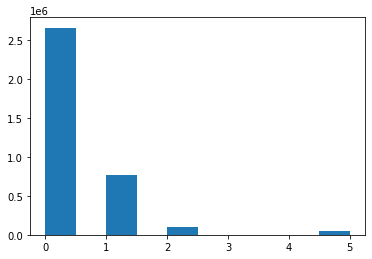

In [36]:
plt.hist(df['M_WEATHER'])

In [47]:
#preprocesing data
print("Before cleaning:",str(len(df)))
#435368
#532536 - usunięcie duplikatów
#511050 - 21k
#475399 - 35k 
#360755 - 115k

df = df[columns]
df = df.dropna(subset=['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])

#w trakcie analizy ..... 
#histogram przed czyszczeniem
#histogram po czyszczeniu
# i dlaczego tak 
#roznica wynosi 21486 jakby była w tylu rekordach pogoda na sztywno ustawiona. przy wyłączeniu samego:
#df = df[df['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]

df = df[df['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]
df['M_SESSION_UID'] = df['M_SESSION_UID'].apply(int)
if(df['TIMESTAMP'].dtypes != DATATYPE):
    df['TIMESTAMP'] = df['TIMESTAMP'].apply(datetime.datetime.fromtimestamp)
df = df[df['M_TIME_OFFSET']==0.0]       # Offset jako 0 na stan faktyczny
#df = df.drop(['M_TIME_OFFSET'], axis=1)
df = df.drop_duplicates()
print("After cleaning: ",str(len(df)))
df

Before cleaning: 3572328
After cleaning:  140615


,TIMESTAMP,M_SESSION_UID,M_TRACK_ID,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TIME_OFFSET
17038,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0,0.0
17041,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0,0.0
17048,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
17115,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0,0.0
17118,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572208,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,0.0
3572215,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3572282,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,4.0,0,0.0
3572285,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,0.0


In [49]:
plt.hist(df['M_WEATHER'])

#new_df = df[df['M_TIME_OFFSET'] ==0 ]
#new_df

,TIMESTAMP,M_SESSION_UID,M_TRACK_ID,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER,M_TIME_OFFSET
17038,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0,0.0
17041,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0,0.0
17048,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
17115,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0,0.0
17118,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572208,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,0.0
3572215,2022-01-16 00:14:50,10862815468833216512,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3572282,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,4.0,0,0.0
3572285,2022-01-16 00:14:51,10862815468833216512,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0,0.0


,M_AIR_TEMPERATURE
TIMESTAMP,
2022-01-21 01:16:50,25
2022-01-21 01:16:50,25
2022-01-21 01:16:50,25
2022-01-21 01:16:50,25
2022-01-21 01:16:50,25
...,...
2022-01-16 00:14:51,25
2022-01-16 00:14:51,25
2022-01-16 00:14:51,25


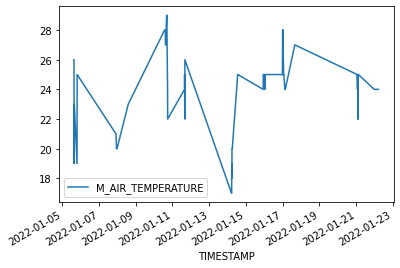

In [48]:
#LSTM - prepere data

df_1 = df.drop(['M_SESSION_UID'], axis=1)
df_2 = df.drop(['M_TRACK_ID'], axis=1)
df_3 = df.drop(['M_SESSION_UID', 'M_TRACK_ID'], axis=1)

df_1.index = pd.to_datetime(df_1[TIMESTAMP], format=FORMAT)
df_2.index = pd.to_datetime(df_2[TIMESTAMP], format=FORMAT)
df_3.index = pd.to_datetime(df_3[TIMESTAMP], format=FORMAT)

#fun 
def df_to_X_y(df, window_size=5):
  df_as_np =df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)





# Sesion ID (_1)




# Track ID (_2)


# ALL (_3)
temp = df_3[DECISION]
temp.plot()
X, y = df_to_X_y(temp)
X.shape, y.shape
temp

#TODO model
